In [1]:
!pip install snowflake-snowpark-python
!pip install snowflake-ml-python
#pip install googletrans

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 8.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1

### Setup Connection

In [2]:
from snowflake.snowpark import Session
import numpy as np
import pandas as pd
# from googletrans import Translator
from snowflake.snowpark.functions import year, month, dayofmonth, dayofweek, to_varchar
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.snowpark.functions import col,sum as sum_, when, avg, median
from snowflake.snowpark.functions import count, lit, min, max
from snowflake.snowpark.types import IntegerType, FloatType, DoubleType, DecimalType, StringType, DateType, TimestampType, LongType
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
connection_parameters_2 = {
...    "account": "YEZEPEO-DATASCIENCE",
...    "user": "VNSHARED",
...    "password": "Columbia2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "MEIXI_DATA", # optional
...   "schema":"PUBLIC",  # optional
...  }

In [4]:
new_session = Session.builder.configs(connection_parameters_2).create()

#### Join Vespucio and equifax data

In [ ]:
# df_consolidated=new_session.table('PUBLIC.TBPAGOS_DOCUMENTOSCOBRO_CONSOLIDADOEXTENDIDO_TS_SHARED')
# df_equifax=new_session.table('PUBLIC.EQUIFAX_SHARED')

In [ ]:
# df_consolidated=new_session.sql('select * from PUBLIC.TBPAGOS_DOCUMENTOSCOBRO_CONSOLIDADOEXTENDIDO_TS_SHARED')
# df_equifax=new_session.sql('select * from PUBLIC.EQUIFAX_SHARED')

In [5]:
df_consolidated=new_session.sql('select * from PUBLIC.CONSOLIDATED_COPY')
df_equifax = new_session.sql('select * from PUBLIC.EQUIFAX_COPY')


In [6]:
# Finding Common columns
common_cols = np.intersect1d(df_consolidated.columns, df_equifax.columns)

# Printing common columns
print ("Common Columns:",common_cols)

Common Columns: ['"FechaExtraccion"' 'RUT']


In [7]:
df_con_equifax=df_consolidated.join(df_equifax.select('"RUT"', '"Score Equifax"'), on='"RUT"', how='left').drop(df_equifax['"FechaExtraccion"'])

In [8]:
# Define the new column name for the second column
new_column_name = 'FechaExtraccion'

# Use withColumnRenamed to create a new DataFrame with the renamed column
df_con_equifax_v = df_con_equifax.withColumnRenamed(df_con_equifax.columns[1], new_column_name)

In [9]:
df_con_equifax.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"      |"NumeroDocumento"  |"NumeroFolio"  |"FechaEmision"  |"FechaVencimiento"  |"FechaRegistro"  |"BusinessPartnerId"  |"CuentaContrato"  |"ClaveReconciliacion"  

In [10]:
total_rows = df_con_equifax_v.count()

# Check each column for missing values by comparing non-null counts to total rows
missing_value_counts = df_con_equifax_v.select(
    [(total_rows - count(col(c))).alias(c + "_missing") for c in df_con_equifax_v.columns]
)

# Show the result, each column name will have a suffix "_missing" showing the count of missing values
missing_value_counts.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
def preprocessing(df):
  df = df.with_column("YEAR_DUE", to_varchar(year(col('"FechaVencimiento"'))))\
                            .with_column("MONTH_DUE", to_varchar(month(col('"FechaVencimiento"'))))\
                            .with_column("DAY_OF_MONTH_DUE", to_varchar(dayofmonth(col('"FechaVencimiento"'))))\
                            .with_column("DAY_OF_WEEK_DUE", to_varchar(dayofweek(col('"FechaVencimiento"'))))\

  # df = df.with_column("YEAR_PAID", to_varchar(year(col('"FechaCompensacion"'))))\
  #                           .with_column("MONTH_PAID", to_varchar(month(col('"FechaCompensacion"'))))\
  #                           .with_column("DAY_OF_MONTH_PAID", to_varchar(dayofmonth(col('"FechaCompensacion"'))))\
  #                           .with_column("DAY_OF_WEEK_DUE", to_varchar(dayofweek(col('"FechaCompensacion"'))))\

  df = df.with_column("YEAR_INVOICED", to_varchar(year(col('"FechaEmision"'))))\
                            .with_column("MONTH_INVOICED", to_varchar(month(col('"FechaEmision"'))))\
                            .with_column("DAY_OF_MONTH_INVOICED", to_varchar(dayofmonth(col('"FechaEmision"'))))\
                            .with_column("DAY_OF_WEEK_INVOICED", to_varchar(dayofweek(col('"FechaEmision"'))))\

  df = df.filter(col("RUT").is_not_null())
  df = df.withColumn('Unpaid', when(col('"StatusCompensacion"') == 'Impaga', 1).otherwise(0))

  #df = df.filter(col('YEAR_INVOICED')!=2024)
  df = df.filter((col('YEAR_INVOICED') == 2023)|(col('YEAR_INVOICED') == 2022)|(col('YEAR_INVOICED') == 2021))


  aggregated_df = df.group_by(col('"RUT"')).agg(
    min(col("YEAR_INVOICED")).alias("first_year_joined"),
    max(col("YEAR_INVOICED")).alias("last_year_present"),
    (max(col("YEAR_INVOICED")) - min(col("YEAR_INVOICED"))).alias("customer_lifespan"),
    (sum_(col('Unpaid')) / count(col('Unpaid')) * 100).alias("default_rate_percent"),  # Calculating default rate as a percentage
    median(col('"ImportePesos"')).alias("median_importe_pesos"),
    median(col('"DiasCompensacion"')).alias("median_dias_compensacion"),
    avg(col('"Score Equifax"')).alias("average_score_equifax")
)

  print(aggregated_df)


    #dropping unique identifiers
  columns_to_drop = ['"NumeroDocumento"', '"NumeroFolio"', '"BusinessPartnerId"', '"RUT"','"CuentaContrato"','"StatusCompensacionTmp"',
                      '"FechaRegistro"','"ClaveReconciliacion"','"Cabecera_FechaHoraCreacion"','"Detalle_FechaHoraCreacion"','"Direccion"','"Nombre"','FECHAEXTRACCION','"DocumentoCompensacion"','"PosicionDocumento"',
                     '"OperacionPrincipal"', '"OperacionParcial"']
  df = df.drop(*columns_to_drop)

  #over 70% missing values
  columns_to_drop2=['"Cabecera_FechaHoraUltimaModificacion"', '"Detalle_FechaHoraUltimaModificacion"']
  df = df.drop(*columns_to_drop2)

  df = df.with_column('"MaxCategoriaVehiculo"', col('"MaxCategoriaVehiculo"').astype("string"))
  df = df.drop('"StatusCompensacion"')
  df = df.drop('"DiasCompensacion"')

  schema = df.schema

  numerical_columns = []
  categorical_columns = []
  datetime_columns=[]

  # Iterate over the schema and check the data type of each column
  for field in schema.fields:
      #print(field.datatype)
      if isinstance(field.datatype, (IntegerType, FloatType, DoubleType, DecimalType, LongType)):
          numerical_columns.append(field.name)
      elif isinstance(field.datatype, StringType):
          categorical_columns.append(field.name)
      elif isinstance(field.datatype, (TimestampType, DateType)):
          datetime_columns.append(field.name)

  df = df.drop(*datetime_columns)

  # for column in categorical_columns:
  #   df = df.with_column(column, col(column).cast("category"))

  selected_columns = ['"ImportePesos"', '"Score Equifax"']
  numerical_columns_x = [col for col in numerical_columns if col in selected_columns]

  # categorical_columns_ohe = [col + "_OHE" for col in categorical_columns]
  # categorical_columns_ohe=['"OperacionPrincipal_OHE"','"OperacionParcial_OHE"','"COMUNA_OHE"',]
  #categorical_columns_ohe = [f'{col[:-1]}_OHE"' if col.endswith('"') else f'{col}_OHE' for col in categorical_columns]
  #categorical_columns_ohe = [f"{col.strip('\"')}_OHE" for col in categorical_columns]
  # categorical_columns_ohe = [(col.strip('"') + '_OHE') for col in categorical_columns]

  num_columns_nor = [col + "_NORM" for col in numerical_columns_x]
  #print(categorical_columns_ohe)

  #Encode categoricals to numeric columns
  # snowml_ohe = snowml.OneHotEncoder(input_cols=categorical_columns, output_cols=categorical_columns_ohe)
  # transformed_df = snowml_ohe.fit(df).transform(df)
  # print(transformed_df.show())

  #Scale numerical columns to prevent bias
  snowml_mms = snowml.MinMaxScaler(input_cols=numerical_columns_x, output_cols=num_columns_nor)
  normalized_df = snowml_mms.fit(df).transform(df)

  normalized_df=  normalized_df.drop(*selected_columns)

    #Add the outlier removal part if required
    #try adding year first joined to see if it changes the accuracy of the model
    #Check multicollinearity

  return normalized_df, aggregated_df, numerical_columns, categorical_columns
  #return df

In [15]:
# df_trial=df_con_equifax_v.limit(100)
df_processed, agg_df, num_cols, cat_cols = preprocessing(df_con_equifax_v)

In [16]:
df_processed.show(5)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"""ImportePesos""_NORM"  |"""Score Equifax""_NORM"  |"COMUNA"  |"CIUDAD"  |"REGION"  |"CantidadCuentasContrato"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"  |"TipoDocumento"  |"TipoProducto"  |"YEAR_DUE"  |"MONTH_DUE"  |"DAY_OF_MONTH_DUE"  |"DAY_OF_WEEK_DUE"  |"YEAR_INVOICED"  |"MONTH_INVOICED"  |"DAY_OF_MONTH_INVOICED"  |"DAY_OF_WEEK_INVOICED"  |"UNPAID"  |"MaxCategoriaVehiculo"  |
--------------------------------------------------------------

In [17]:
agg_df.show(50)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"       |"FIRST_YEAR_JOINED"  |"LAST_YEAR_PRESENT"  |"CUSTOMER_LIFESPAN"  |"DEFAULT_RATE_PERCENT"  |"MEDIAN_IMPORTE_PESOS"  |"MEDIAN_DIAS_COMPENSACION"  |"AVERAGE_SCORE_EQUIFAX"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|15543833-9  |2022                 |2023                 |1.0                  |28.571400               |5.0                     |-14.0                       |620.0                    |
|16852031-K  |2021                 |2023                 |2.0                  |93.103400               |231.0                   |-16.0                       |661.0                    |
|4902995-0   |2023                 |2023                 |0.0         

In [22]:
def dataset_shape(df):
    # Get the number of rows
    num_rows = df.count()
    # Get the number of columns
    num_columns = len(df.columns)
    # Shape of the DataFrame
    shape = (num_rows, num_columns)
    print("Shape of the given dataset", shape)

In [23]:
sampled_df = agg_df.sample(0.001)
dataset_shape(sampled_df)

Shape of the given dataset (2706, 8)


In [24]:
pd_agg = agg_df.to_pandas()

In [25]:
len(pd_agg)

2711294

In [39]:
pd_agg.dropna(inplace=True)
pd_agg

,RUT,FIRST_YEAR_JOINED,LAST_YEAR_PRESENT,CUSTOMER_LIFESPAN,DEFAULT_RATE_PERCENT,MEDIAN_IMPORTE_PESOS,MEDIAN_DIAS_COMPENSACION,AVERAGE_SCORE_EQUIFAX
0,14074835-8,2021,2023,2.0,0.0000,404.0,11.0,402.0
1,13152253-3,2021,2023,2.0,0.0000,578.0,6.0,857.0
2,15794116-K,2021,2023,2.0,0.0000,50.0,-8.0,710.0
3,10221328-9,2021,2023,2.0,0.0000,33.0,10.0,402.0
4,5378582-4,2023,2023,0.0,0.0000,69.0,125.0,642.0
...,...,...,...,...,...,...,...,...
2711285,8694347-6,2022,2023,1.0,0.0000,5.0,-9.0,708.0
2711287,16546582-2,2023,2023,0.0,0.0000,1.0,-15.0,125.0
2711290,7193824-7,2021,2023,2.0,0.0000,377.0,0.0,961.0
2711291,8389143-2,2022,2023,1.0,57.1429,301.0,70.5,644.0


In [43]:
import pandas as pd
from scipy.stats import spearmanr
spearman_corr, p_value = spearmanr(pd_agg["CUSTOMER_LIFESPAN"], pd_agg["DEFAULT_RATE_PERCENT"])
print("Spearman correlation coefficient for CUSTOMER_LIFESPAN:", spearman_corr)
print("Spearman p-value for CUSTOMER_LIFESPAN:", p_value)

Spearman correlation coefficient for CUSTOMER_LIFESPAN: 0.10805606752199057
Spearman p-value for CUSTOMER_LIFESPAN: 0.0


In [44]:
spearman_corr, p_value = spearmanr(pd_agg["MEDIAN_DIAS_COMPENSACION"], pd_agg["DEFAULT_RATE_PERCENT"])
print("Spearman correlation coefficient for MEDIAN_DIAS_COMPENSACION:", spearman_corr)
print("Spearman p-value for MEDIAN_DIAS_COMPENSACION:", p_value)

Spearman correlation coefficient for MEDIAN_DIAS_COMPENSACION: -0.07604638192129147
Spearman p-value for MEDIAN_DIAS_COMPENSACION: 0.0


In [45]:
spearman_corr, p_value = spearmanr(pd_agg["MEDIAN_IMPORTE_PESOS"], pd_agg["DEFAULT_RATE_PERCENT"])
print("Spearman correlation coefficient for MEDIAN_IMPORTE_PESOS:", spearman_corr)
print("Spearman p-value for MEDIAN_IMPORTE_PESOS:", p_value)

Spearman correlation coefficient for MEDIAN_IMPORTE_PESOS: 0.14160654956415672
Spearman p-value for MEDIAN_IMPORTE_PESOS: 0.0


In [42]:
spearman_corr, p_value = spearmanr(pd_agg["AVERAGE_SCORE_EQUIFAX"], pd_agg["DEFAULT_RATE_PERCENT"])
print("Spearman correlation coefficient for AVERAGE_SCORE_EQUIFAX:", spearman_corr)
print("Spearman p-value for AVERAGE_SCORE_EQUIFAX:", p_value)

Spearman correlation coefficient for AVERAGE_SCORE_EQUIFAX: -0.2172377800404562
Spearman p-value for AVERAGE_SCORE_EQUIFAX: 0.0


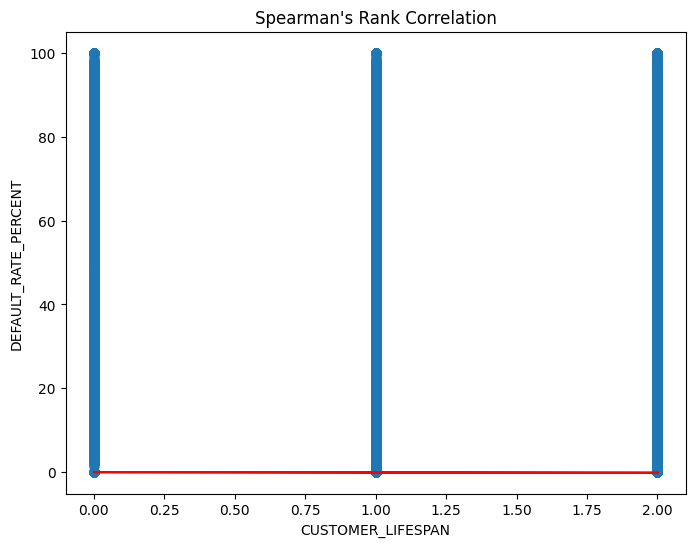

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(pd_agg["CUSTOMER_LIFESPAN"], pd_agg["DEFAULT_RATE_PERCENT"], alpha=0.5)
plt.title("Spearman's Rank Correlation")
plt.xlabel("CUSTOMER_LIFESPAN")
plt.ylabel("DEFAULT_RATE_PERCENT")

# Fit a line based on the Spearman correlation coefficient
x = pd_agg["CUSTOMER_LIFESPAN"]
y = spearman_corr * x
plt.plot(x, y, color='red')

plt.show()

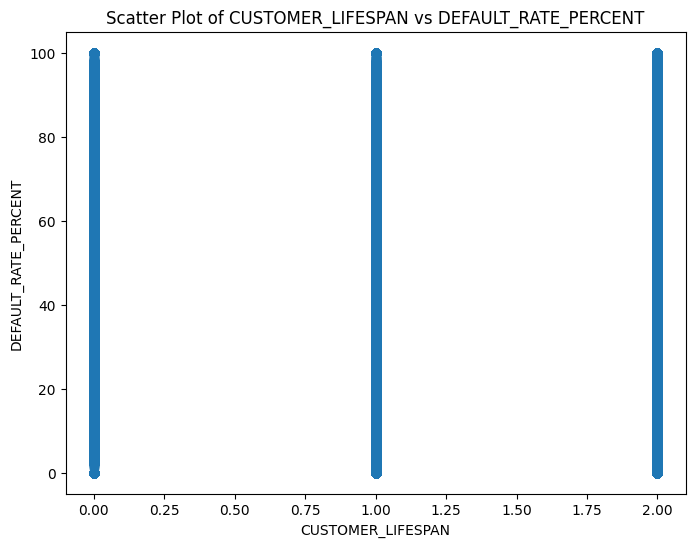

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(pd_agg["CUSTOMER_LIFESPAN"], pd_agg["DEFAULT_RATE_PERCENT"], alpha=0.5)
plt.title("Scatter Plot of CUSTOMER_LIFESPAN vs DEFAULT_RATE_PERCENT")
plt.xlabel("CUSTOMER_LIFESPAN")
plt.ylabel("DEFAULT_RATE_PERCENT")
plt.show()

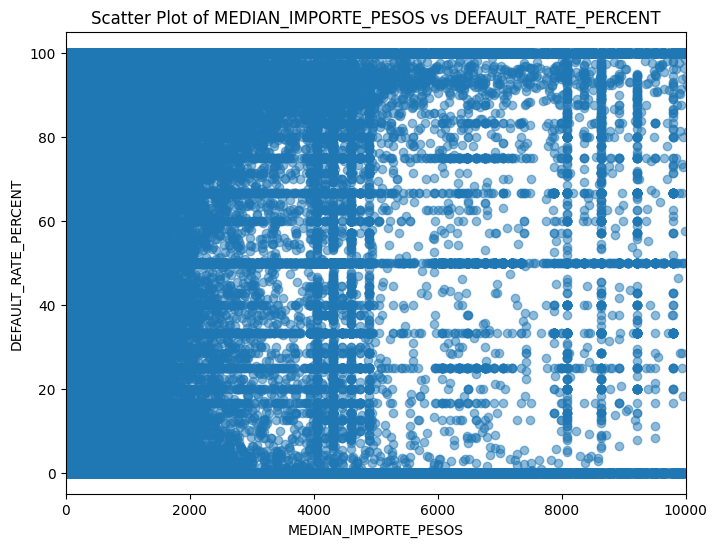

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(pd_agg["MEDIAN_IMPORTE_PESOS"], pd_agg["DEFAULT_RATE_PERCENT"], alpha=0.5)
plt.title("Scatter Plot of MEDIAN_IMPORTE_PESOS vs DEFAULT_RATE_PERCENT")
plt.xlabel("MEDIAN_IMPORTE_PESOS")
plt.ylabel("DEFAULT_RATE_PERCENT")
plt.xlim(0, 10000)
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
X = agg_df[['MEDIAN_IMPORTE_PESOS', 'AVERAGE_SCORE_EQUIFAX', 'CUSTOMER_LIFESPAN']]
y = agg_df['DEFAULT_RATE_PERCENT']
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

ValueError: Expected 2D array, got scalar array instead:
array=<snowflake.snowpark.dataframe.DataFrame object at 0x7a83d052f910>.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
rate = [row['DEFAULT_RATE_PERCENT'] for row in agg_df]
pesos = [row['MEDIAN_IMPORTE_PESOS'] for row in agg_df]
equifax = [row['AVERAGE_SCORE_EQUIFAX'] for row in agg_df]
lifespan = [row['CUSTOMER_LIFESPAN'] for row in agg_df]

data1 = {
    'Rate': rate,
    'Pesos': pesos,
    'Equifax': equifax,
    'Lifespan': lifespan
}
df = pd.DataFrame(data1)

In [ ]:
df

,Rate,Pesos,Equifax,Lifespan
0,Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING]
1,Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING]
2,Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING]
3,Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING]
4,Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING]
5,Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING]
6,Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING]
7,Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING],Column[SUBFIELDSTRING]


In [ ]:
agg_df['MEDIAN_IMPORTE_PESOS']

Column("MEDIAN_IMPORTE_PESOS")

In [ ]:
X1 = df['Pesos']  # Independent variable
y = df['Rate']  # Dependent variable

# Add a constant to the model (intercept)
X1 = sm.add_constant(X1)

# Create the OLS model
model = sm.OLS(y, X1)

# Fit the model
results = model.fit()

print(results.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
X1

,const,Pesos
0,1.0,Column[SUBFIELDSTRING]
1,1.0,Column[SUBFIELDSTRING]
2,1.0,Column[SUBFIELDSTRING]
3,1.0,Column[SUBFIELDSTRING]
4,1.0,Column[SUBFIELDSTRING]
5,1.0,Column[SUBFIELDSTRING]
6,1.0,Column[SUBFIELDSTRING]
7,1.0,Column[SUBFIELDSTRING]


In [ ]:
num_cols

['"ImportePesos"',
 '"CantidadCuentasContrato"',
 '"CantidadVehiculos"',
 '"Score Equifax"',
 'UNPAID']

In [ ]:
cat_cols

['"OperacionPrincipal"',
 '"OperacionParcial"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 'YEAR_DUE',
 'MONTH_DUE',
 'DAY_OF_MONTH_DUE',
 'DAY_OF_WEEK_DUE',
 'YEAR_INVOICED',
 'MONTH_INVOICED',
 'DAY_OF_MONTH_INVOICED',
 'DAY_OF_WEEK_INVOICED',
 '"MaxCategoriaVehiculo"']

In [ ]:
# Define the name of the table you want to create or overwrite in Snowflake
table_name = 'table_with_split'

# Write the DataFrame to a new table in Snowflake
df_processed.write.mode('overwrite').save_as_table(table_name)

In [ ]:
df_model=new_session.sql('select * from TABLE_WITH_SPLIT ')
print(df_model.columns)

['"""ImportePesos""_NORM"', '"""Score Equifax""_NORM"', '"OperacionPrincipal"', '"OperacionParcial"', 'COMUNA', 'CIUDAD', 'REGION', '"CantidadCuentasContrato"', '"CantidadVehiculos"', '"TramoMoraCliente"', '"TramoMora"', '"Inhabilitado"', '"Concesionaria"', '"TipoCliente"', '"TipoOperacion"', '"TipoDocumento"', '"TipoProducto"', 'YEAR_PAID', 'MONTH_PAID', 'DAY_OF_MONTH_PAID', 'DAY_OF_WEEK_DUE', 'YEAR_INVOICED', 'MONTH_INVOICED', 'DAY_OF_MONTH_INVOICED', 'DAY_OF_WEEK_INVOICED', 'UNPAID', '"MaxCategoriaVehiculo"']


In [ ]:
df_model_trial=df_model.limit(100000)

In [ ]:
# Split the data into train and test sets
train_df, test_df = df_model_trial.random_split(weights=[0.8, 0.2], seed=0)

In [ ]:
train_df_X=train_df.drop('UNPAID')
train_df_Y=train_df.select(col('UNPAID'))

In [ ]:
train_df_X.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"""ImportePesos""_NORM"  |"""Score Equifax""_NORM"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"    |"CIUDAD"   |"REGION"  |"CantidadCuentasContrato"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"  |"TipoDocumento"      |"TipoProducto"  |"YEAR_PAID"  |"MONTH_PAID"  |"DAY_OF_MONTH_PAID"  |"DAY_OF_WEEK_DUE"  |"YEAR_INVOICED"  |"MONTH_INVOICED"  |"DAY_OF_MONTH_INVOICED"  |"DAY_OF_WEEK_INVOICED"  |"M

In [ ]:
train_df_Y.show()

------------
|"UNPAID"  |
------------
|1         |
|1         |
|1         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
------------



In [ ]:
train_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"""ImportePesos""_NORM"  |"""Score Equifax""_NORM"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"     |"CIUDAD"    |"REGION"  |"CantidadCuentasContrato"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"   |"TipoDocumento"  |"TipoProducto"  |"YEAR_PAID"  |"MONTH_PAID"  |"DAY_OF_MONTH_PAID"  |"DAY_OF_WEEK_DUE"  |"YEAR_INVOICED"  |"MONTH_INVOICED"  |"DAY_OF_MONTH_INVOICED"  |"DAY_OF_WEEK_INVOI

In [ ]:
test_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"""ImportePesos""_NORM"  |"""Score Equifax""_NORM"  |"OperacionPrincipal"  |"OperacionParcial"  |"COMUNA"       |"CIUDAD"    |"REGION"  |"CantidadCuentasContrato"  |"CantidadVehiculos"  |"TramoMoraCliente"  |"TramoMora"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoOperacion"   |"TipoDocumento"      |"TipoProducto"  |"YEAR_PAID"  |"MONTH_PAID"  |"DAY_OF_MONTH_PAID"  |"DAY_OF_WEEK_DUE"  |"YEAR_INVOICED"  |"MONTH_INVOICED"  |"DAY_OF_MONTH_INVOICED"  |"DAY_O

In [ ]:
all_columns = df_model_trial.columns
filtered_columns = [col for col in all_columns if col != "UNPAID"]

input_columns=filtered_columns
label_columns="UNPAID"
output_columns="PREDICTED_DEFAULT"

In [ ]:
input_columns

['"""ImportePesos""_NORM"',
 '"""Score Equifax""_NORM"',
 '"OperacionPrincipal"',
 '"OperacionParcial"',
 'COMUNA',
 'CIUDAD',
 'REGION',
 '"CantidadCuentasContrato"',
 '"CantidadVehiculos"',
 '"TramoMoraCliente"',
 '"TramoMora"',
 '"Inhabilitado"',
 '"Concesionaria"',
 '"TipoCliente"',
 '"TipoOperacion"',
 '"TipoDocumento"',
 '"TipoProducto"',
 'YEAR_PAID',
 'MONTH_PAID',
 'DAY_OF_MONTH_PAID',
 'DAY_OF_WEEK_DUE',
 'YEAR_INVOICED',
 'MONTH_INVOICED',
 'DAY_OF_MONTH_INVOICED',
 'DAY_OF_WEEK_INVOICED',
 '"MaxCategoriaVehiculo"']

In [ ]:
from snowflake.ml.modeling.xgboost import XGBRegressor
# Define the XGBRegressor
regressor = XGBRegressor(
    input_cols=input_columns,
    label_cols=label_columns,
    output_cols=output_columns
)


In [ ]:
# Train
regressor.fit(train_df)

SnowparkSQLException: (1300) (1304): 01b40b5d-0105-1df9-0004-c9db0013f1b6: 100357 (P0000): Python Interpreter Error:
Traceback (most recent call last):
  File "/home/udf/80337836/udf_py_123455646.zip/udf_py_123455646.py", line 76, in compute
    return func(session,arg1,arg2,arg3,arg4,arg5,arg6,arg7)
  File "/usr/local/lib/python3.10/dist-packages/snowflake/ml/modeling/_internal/snowpark_implementations/snowpark_trainer.py", line 233, in fit_wrapper_function
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/sklearn.py", line 988, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/sklearn.py", line 448, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/sklearn.py", line 908, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/core.py", line 743, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/data.py", line 970, in dispatch_data_backend
    return _from_pandas_df(data, enable_categorical, missing, threads,
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/data.py", line 417, in _from_pandas_df
    data, feature_names, feature_types = _transform_pandas_df(
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/data.py", line 391, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "/usr/lib/python_udf/bde3624bc62adcfa9b4bcca39aaadf3cae31d009ca3c98b5429fc3575c4456fd/lib/python3.10/site-packages/xgboost/data.py", line 283, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:"OperacionPrincipal": object, "OperacionParcial": object, COMUNA: object, CIUDAD: object, REGION: object, "TramoMoraCliente": object, "TramoMora": object, "Inhabilitado": object, "Concesionaria": object, "TipoCliente": object, "TipoOperacion": object, "TipoDocumento": object, "TipoProducto": object, YEAR_PAID: object, MONTH_PAID: object, DAY_OF_MONTH_PAID: object, DAY_OF_WEEK_DUE: object, YEAR_INVOICED: object, MONTH_INVOICED: object, DAY_OF_MONTH_INVOICED: object, DAY_OF_WEEK_INVOICED: object, "MaxCategoriaVehiculo": object
 in function SNOWPARK_TEMP_PROCEDURE_WSMJ105D2A with handler udf_py_123455646.compute

In [ ]:
# Predict
result = regressor.predict(test_df)

In [ ]:
from snowflake.ml.modeling.metrics.correlation import correlation

In [ ]:
corr_df = correlation(df=df_model)
corr_df

,"""""""ImportePesos""""_NORM""","""""""Score Equifax""""_NORM""","""CantidadCuentasContrato""","""CantidadVehiculos""",UNPAID
"""""""ImportePesos""""_NORM""",1.000000,NaN,0.011998,NaN,0.020792
"""""""Score Equifax""""_NORM""",NaN,NaN,NaN,NaN,NaN
"""CantidadCuentasContrato""",0.011998,NaN,1.000000,NaN,-0.023315
"""CantidadVehiculos""",NaN,NaN,NaN,NaN,NaN
UNPAID,0.020792,NaN,-0.023315,NaN,1.000000


In [46]:
new_session.close()